## **Notebook Contents**

- [Import Libraries](#importlibraries)  
- [Import Dataframes](#importdataframes)
- [Merge the Data](#mergedata)  
- [Train/Test Split](#train/test/split)   
- [Function for Cleaning](#cleaningfunction)  
- [Word EDA](#wordeda)  
- [Simple Logistic Regression without Gridsearch](#simplelogreg) 
- [Gridsearched Count Vectorizer for Logistic Regression and Naive Bayes](#grcvlrnb)  
- [Confusion Matrix](#cm)  
- [Scores](#scores)

<a name="importlibraries"></a>
## **Import Libraries**

In [91]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from bs4 import BeautifulSoup       
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer

<a name="importdataframes"></a>
## **Import Dataframes**

In [92]:
data_ai = pd.read_csv('../project_3-master/data/data_ai.csv')
data_ml = pd.read_csv('../project_3-master/data/data_ml.csv')

In [93]:
data_ai.head(1)

,subreddit,title,selftext
0,artificial,Could AI ethics draw on non-Western philosophi...,NaN


In [94]:
data_ml.head(1)

,subreddit,title,selftext
0,MachineLearning,[R] Taming pretrained transformers for eXtreme...,New X-Transformer model from Amazon Research\n...


In [95]:
print(f'The shape of the AI dataframe is {data_ai.shape}')
print(f'The shape of the ML dataframe is {data_ml.shape}')

The shape of the AI dataframe is (31299, 3)
The shape of the ML dataframe is (31299, 3)


<a name="mergedata"></a>
## **Merge the Data**

In [96]:
df = data_ai.append(data_ml).reset_index()

In [97]:
df.drop(columns='index',inplace=True)

In [98]:
print(f'The shape of the merged AI and ML dataframes are {df.shape}')

The shape of the merged AI and ML dataframes are (62598, 3)


In [99]:
df.isnull().sum()

subreddit        0
title            0
selftext     31046
dtype: int64

**Let's see what a title might look like:**

In [100]:
df['title'][0]

'Could AI ethics draw on non-Western philosophies to help reframe AI ethics'

## **Word Cleaning**

In [101]:
# A lot of NaN values however we are not using the selftext in the modeling
df.isna().sum()

subreddit        0
title            0
selftext     31046
dtype: int64

In [102]:
# Lets drop the selftext column since we do not use it
df.drop(columns='selftext', inplace = True)

In [103]:
# It is now dropped
df.head(1)

,subreddit,title
0,artificial,Could AI ethics draw on non-Western philosophi...


In [104]:
# Check for balanced classes
df['subreddit'].value_counts()

artificial         31299
MachineLearning    31299
Name: subreddit, dtype: int64

In [107]:
# TEXT CLEANING FUNCTION FOR EVERY POST IN BOTH SUBREDDITS TITLE + SELFTEXT

# These will be replaced by a space ' ' 
symbol_replace_space = re.compile('[/(){}\[\]\|@,;]')

# We will get rid of all these in the function below
bad_symbols = re.compile('[^0-9a-z #+_]')

# We will get rid of all of the stopwords
STOPWORDS = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def clean_text(text):

    # Make all of the text lower case
    text = text.lower() 

    # Replace symbol_replace_space with a space 
    text = symbol_replace_space.sub(' ', text)
    
    # Replace bad_symbols with a space
    text = bad_symbols.sub('', text) 
    
    # This gets rid of the integers
    text = re.sub(r'\d+', '', text) 
    
#     [lemmatizer.lemmatize(i) for i in text]
    
    # remove stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

# Applying the clean_text function above to every title in df['title']
df['title'] = df['title'].apply(clean_text)

In [108]:
# We can see the the new dataframe'
df

,subreddit,title
0,artificial,could ai ethics draw nonwestern philosophies h...
1,artificial,realistic simulation tearing meat peeling chee...
2,artificial,r using deep rl model human locomotion control...
3,artificial,artificial intelligence easily beats human fig...
4,artificial,foiling illicit cryptocurrency mining artifici...
...,...,...
62593,MachineLearning,things wish knew starting domain machine learning
62594,MachineLearning,anyone created formal database word meaning
62595,MachineLearning,p demo arbitrary style transfer styleattention...
62596,MachineLearning,r triplet loss image retrieval


## **Word EDA**

In [110]:
ml = df[df['subreddit'] == 'MachineLearning']
ai = df[df['subreddit'] == 'artificial']

In [120]:
top_words_ml = {}
for i in ml[:-1]:
    top_words_ml[i] =  ml[i].sum()
# top_words to dataframe sorted by highest occurance
most_freq_ml = pd.DataFrame(sorted(top_words_ml.items(), key = lambda x: x, reverse = True))
most_freq_ml[:15]

,0,1
0,title,r taming pretrained transformers extreme multi...
1,subreddit,MachineLearningMachineLearningMachineLearningM...


<a name="train/test/split"></a>
## **Train/Test Split**

In [29]:
X = df[['title']]
y = df['subreddit']

In [30]:
X.shape

(62598, 1)

In [31]:
y.shape

(62598,)

In [32]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(46948, 1)
(15650, 1)
(46948,)
(15650,)


## **Count Vectorizer**

In [35]:
# Instantiate the "CountVectorizer" object, which is scikit-learn's bag of words tool
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 3000,
                             min_df = 2
                             )

In [37]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(X_train['title'])

test_data_features = vectorizer.transform(X_test['title'])

# Numpy arrays are easy to work with, so convert the result to an array.
train_data_features = train_data_features.toarray()

In [38]:
train_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## **Simple Logistic Regression**

In [41]:
# Instantiate the Logistic Regression
lr = LogisticRegression(solver='liblinear')

In [42]:
lr.fit(train_data_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
print(f"Logistic Regression training accuracy is: {lr.score(train_data_features, y_train)}")
print(f"Logistic Regression testing accuracy is: {lr.score(test_data_features, y_test)}")

Logistic Regression training accuracy is: 0.8310684161199625
Logistic Regression testing accuracy is: 0.8037699680511182


## **Gridsearched Count Vectorizer for Logistic Regression and Naive Bayes**

In [66]:
# Pipeline for CountVectorizer for Naive Bayes and Logisitc Regression
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())    
])

In [67]:
pipe_params = {
    'cvec__max_features': [5000, 8000, 10_000, 15_000, 20_000],
    'cvec__min_df': [2, 3, 4],
    'cvec__ngram_range': [(1, 1), (1,2), (1, 3)],
#     'cvec__max_df': [.90, .95]
    }

In [68]:
# Instantiate GridSearchCV.

#LR
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

#NB
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [69]:
gs_cvec_lr.fit(X_train['title'], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [70]:
gs_cvec_nb.fit(X_test['title'], y_test)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [71]:
gs_cvec_lr.best_params_

{'cvec__max_features': 20000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}

In [72]:
gs_cvec_nb.best_params_

{'cvec__max_features': 15000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}

In [73]:
# Score model train & test for Logisitic Regression
print(f"Logistic Regression with Gridsearch training accuracy is: {gs_cvec_lr.score(X_train['title'], y_train)}")
print(f"Logistic Regression with Gridsearch testing accuracy is: {gs_cvec_lr.score(X_test['title'], y_test)}")

Logistic Regression with Gridsearch training accuracy is: 0.8863636363636364
Logistic Regression with Gridsearch testing accuracy is: 0.809776357827476


In [74]:
# Score model on train & test for Naive Bayes
print(f"Naive Bayes with Gridsearch training accuracy is: {gs_cvec_nb.score(X_train['title'], y_train)}")
print(f"Naive Bayes with Gridsearch testing accuracy is: {gs_cvec_nb.score(X_test['title'], y_test)}")

Naive Bayes with Gridsearch training accuracy is: 0.8048266166822868
Naive Bayes with Gridsearch testing accuracy is: 0.8615335463258786


<a name="cm"></a>
## **Confusion Matrix**

### **Confusion Matrix for Simple Logistic Regression**

In [78]:
# Get predictions for Simple Logisitic Regression
preds = lr.predict(test_data_features)

# Confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

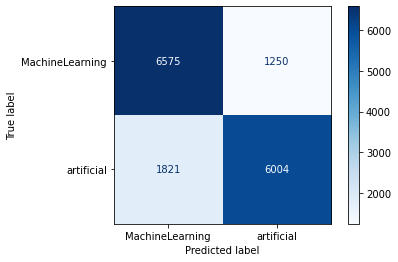

In [79]:
plot_confusion_matrix(lr, test_data_features, y_test, cmap='Blues', values_format='d');

True Negative - 6575   
True Positive - 6004    
False Negative - 1821  
False Positive - 6004  

### **Confusion Matrix for Logistic Regression with Gridsearch**

In [58]:
# Get predictions for Logisitc Regression with Gridsearch
preds_2 = gs_cvec_lr.predict(X_test['title'])

# Confusion matrix values
tn_2, fp_2, fn_2, tp_2 = confusion_matrix(y_test, preds_2).ravel()

Logistic Regression with Gridsearch training accuracy is: 0.8863636363636364
Logistic Regression with Gridsearch testing accuracy is: 0.809776357827476


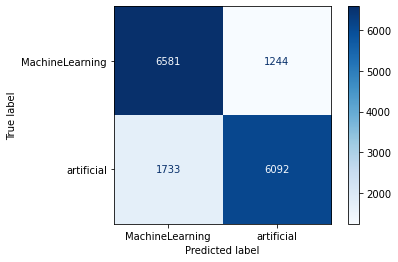

In [75]:
plot_confusion_matrix(gs_cvec_lr, X_test['title'], y_test, cmap = 'Blues', values_format='d');
print(f"Logistic Regression with Gridsearch training accuracy is: {gs_cvec_lr.score(X_train['title'], y_train)}")
print(f"Logistic Regression with Gridsearch testing accuracy is: {gs_cvec_lr.score(X_test['title'], y_test)}")

True Negative - 6568    
True Positive - 6051    
False Negative - 1774    
False Positive - 1257    

### **Confusion Matrix for Naive Bayes with Gridsearch**

In [76]:
# Get predictions for Naive Bayes with Gridsearch
preds_3 = gs_cvec_nb.predict(X_test['title'])

# Confusion matrix values
tn_2, fp_2, fn_2, tp_2 = confusion_matrix(y_test, preds_3).ravel()

Naive Bayes with Gridsearch training accuracy is: 0.8048266166822868
Naive Bayes with Gridsearch testing accuracy is: 0.8615335463258786


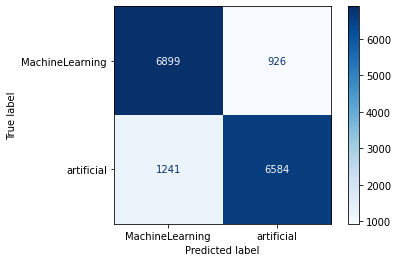

In [77]:
plot_confusion_matrix(gs_cvec_nb, X_test['title'], y_test, cmap='Blues', values_format='d');
print(f"Naive Bayes with Gridsearch training accuracy is: {gs_cvec_nb.score(X_train['title'], y_train)}")
print(f"Naive Bayes with Gridsearch testing accuracy is: {gs_cvec_nb.score(X_test['title'], y_test)}")

True Negative - 6739  
True Positive - 6318  
False Negative - 1507  
False Positive - 1086

Sensitivity, Specificity, Precision, 

## **Scores**

Logistic Regression training accuracy is: 0.8310684161199625  
Logistic Regression testing accuracy is: 0.8037699680511182  

Logistic Regression with Gridsearch training accuracy is: 0.8446792195620687  
Logistic Regression with Gridsearch testing accuracy is: 0.8063258785942492    

Naive Bayes with Gridsearch training accuracy is: 0.7991394734599983  
Naive Bayes with Gridsearch training accuracy is: 0.8343130990415335  